## **Fixed Ordering Tutorial**

The first of the new features is the ability to input a fixed ordering to the fMRI simulations. Normally, when the base package optimizes, it generates a new ordering, but by providing a fixed order at the start, you can restrict the optimization to follow it, randomizing only the intertrial intervals.

**Use Case:** For experiments fixed stimuli ordering for an fMRI experiment and looking to optimize the intertrial intervals.

The following variable was created as an input parameter
* **`order`** `(list of ints or None)`
    * Allows the user to input their own custom order for their experiment.
    * If `order` is provided, 
        * `self.order_fixed` (boolean) is set to **True**. 
        * The order becomes fixed and will be used for all designs and optimization.

This is added to the Experiment class and modifications are made to the classes.py in the Neurodesign package to ensure the ordering isn’t changed



### **Base Example (Ordering is not fixed)**

First, we will look at an example without the fixed ordering in the Experiment.

In [1]:
import numpy as np
import neurodesign
import matplotlib.pyplot as plt

In [2]:
import os
# Since Neurodesign uses multi-threading internally, limit the number of threads
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [3]:
exp = neurodesign.Experiment(
    TR=2,                        # Repetition time (TR) of fMRI acquisition in seconds
    n_trials=20,                 # Number of trials (short toy example)
    P=[0.25, 0.25, 0.25, 0.25],           # Condition probabilities: Condition 2 is slightly overrepresented
    C=[[1,0, -1, 0],[1, 0, 0, -1], [0, 1, -1, 0],  [0, 1, 0,-1]],  # Contrasts: C1 vs C3, C1 vs C4
    n_stimuli=4,                 # Total number of stimulus conditions
    rho=0.3,                     # Temporal autocorrelation in fMRI noise
    stim_duration=1,            # Duration of each stimulus (in seconds)
    t_pre=0.5,                  # Pre-stimulus baseline (e.g., fixation)
    t_post=2,                   # Post-stimulus period (e.g., feedback)
    ITImodel="exponential",     # Inter-trial interval (ITI) sampling model
    ITImin=1,                   # Minimum ITI
    ITImax=4,                   # Maximum ITI
    ITImean=2.5,                # Mean ITI
)

/Users/atharvumap/Documents/Projects/neurodesign_plus/.venv/lib/python3.13/site-packages/neurodesign/classes.py:643: UserWarning: the resolution is adjusted to be a multiple of the TR. New resolution: 0.1
  warnings.warn(
/Users/atharvumap/Documents/Projects/neurodesign_plus/.venv/lib/python3.13/site-packages/neurodesign/classes.py:811: RuntimeWarning: divide by zero encountered in log
  res = (h - 1) * np.log(s) + h * np.log(l) - l * s - np.log(gamma(h))


Notice that when we define a design ourselves, we can get the ideal ordering that we want, but it **DOES NOT** have optimized the metrics.

For this example, we will say the desired fixed ordering we have is:

    [0, 1, 0, 1, 2, 3, 0, 1, 0, 1, 2, 3, 0, 1, 0, 1, 2, 3, 0, 1]

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.19859016e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.24333304e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.08746121e-01  5.41264075e-04  0.00000000e+00  0.00000000e+00]
 [ 1.50213325e-01  7.69440571e-02  0.00000000e+00  0.00000000e+00]
 [ 6.76055106e-02  2.01775345e-01  0.00000000e+00  0.00000000e+00]
 [ 2.01072719e-02  1.75550780e-01  0.00000000e+00  0.00000000e+00]
 [ 1.06966076e-01  8.98447040e-02  0.00000000e+00  0.00000000e+00]
 [ 1.90543157e-01  2.78227477e-02  0.00000000e+00  0.00000000e+00]
 [ 1.37201193e-01  3.19258211e-02  0.00000000e+00  0.00000000e+00]
 [ 5.83640914e-02  1.61332400e-01  0.00000000e+00  0.00000000e+00]
 [ 9.67388192e-03  1.77855241e-01  2.07094952e-06  0.00000000e+00]
 [-1.28526367e-02  1.00494850e-01  3.60489092e-02  0.00000000e+00]
 [-1.99313276e-02  3.36642176e-02  1.78151772e-01  0.00000000e+00]
 [-1.84134831e-02 -2.07333318e-03  1.96115202e-01  2.71005447e

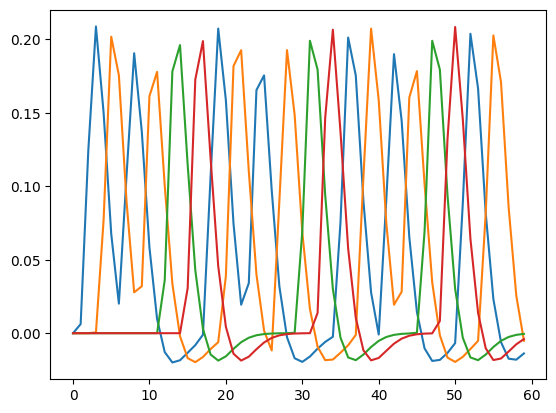

In [4]:
# In this design I am manually creating the order and the onsets
order=[0, 1, 0, 1, 2, 3] * 3

design = neurodesign.Design(
    order=order + [0, 1],  # Repeating sequence of conditions (C0, C1, C0, C1, C2, C3)
    ITI = neurodesign.generate.iti(                   # ITIs drawn from exponential distribution
        ntrials=20, 
        model="exponential", 
        min=1, 
        mean=2, 
        max=4, 
        seed=1234
    )[0],             
    experiment=exp,
    # onsets = onsets
)

# Compute the convolved design matrix and evaluate design quality
design.designmatrix()
print(design.Xconv)
plt.plot(design.Xconv)

Now let's look at what happens when we run our optimization and look at our metrics and resulting graph.

In [5]:
population = neurodesign.Optimisation(
    experiment=exp,
    R=[1, 0, 0], # 100% blocked, 0% random, 0% msequence
    weights=[0, 0.5, 0.25, 0.25],  # Weights for Fe, Fd, confounding, and frequency
    preruncycles=10,               # Warm-up iterations
    cycles=100,                    # Main genetic algorithm iterations
    folder="./",                   # Output folder for results
    seed=100                       # Seed for reproducibility
)

population.optimise()             # Run the optimization

/Users/atharvumap/Documents/Projects/neurodesign_plus/.venv/lib/python3.13/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [6]:
best_design = population.bestdesign  # The best subject from the final generation

print(f"Fd (detection efficiency): {best_design.Fd}")
print(f"Ff (estimation efficiency): {best_design.Ff}")
print(f"Fc (confounding): {best_design.Fc}")
print(f"Fe (stimulus frequency balance): {best_design.Fe}")

Fd (detection efficiency): 1.0847722604952812
Ff (estimation efficiency): 1.0
Fc (confounding): 0.6781214203894617
Fe (stimulus frequency balance): 0


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  6.19859016e-03  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.24333304e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.08816676e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.05186338e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.59656831e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.02265716e-01  9.04714674e-09  0.00000000e+00]
 [ 0.00000000e+00  9.25040703e-02  2.56482899e-02  0.00000000e+00]
 [ 0.00000000e+00  1.68152644e-02  1.66721504e-01  0.00000000e+00]
 [ 0.00000000e+00 -1.82099427e-02  2.01196927e-01  0.00000000e+00]
 [ 0.00000000e+00 -2.85295477e-02  1.65482200e-01  0.00000000e+00]
 [ 0.00000000e+00 -2.62879966e-02  2.31727918e-01  0.00000000e+00]
 [ 0.00000000e+00 -1.91650137e-02  1.98962570e-01  2.71005447e-07]
 [ 0.00000000e+00 -1.18436912e-02  9.70112065e-02  3.06085361e-02]
 [ 0.00000000e+00 -6.40491502e-03  2.14881718e-02  1.72640590e

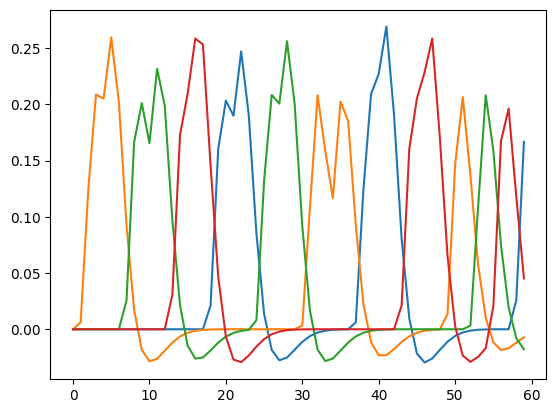

In [7]:
# Compute the convolved bestdesign matrix and evaluate design quality
best_design.designmatrix()
print(best_design.Xconv)
plt.plot(best_design.Xconv)

**Notice that the optimized stimuli ordering is different from the desired ordering that we gave in our sample design.** This aligns with what we expect from the base packages implementation, but if we want fixed ordering, we can then add the modifications parameter.

Now, let's modify the experiment's definition to include the order parameter

In [8]:
exp_fixed = neurodesign.Experiment(
    TR=2,                        # Repetition time (TR) of fMRI acquisition in seconds
    n_trials=20,                 # Number of trials (short toy example)
    P=[0.25, 0.25, 0.25, 0.25],           # Condition probabilities: Condition 2 is slightly overrepresented
    C=[[1,0, -1, 0],[1, 0, 0, -1], [0, 1, -1, 0],  [0, 1, 0,-1]],  # Contrasts: C1 vs C3, C1 vs C4
    n_stimuli=4,                 # Total number of stimulus conditions
    rho=0.3,                     # Temporal autocorrelation in fMRI noise
    stim_duration=1,            # Duration of each stimulus (in seconds)
    t_pre=0.5,                  # Pre-stimulus baseline (e.g., fixation)
    t_post=2,                   # Post-stimulus period (e.g., feedback)
    ITImodel="exponential",     # Inter-trial interval (ITI) sampling model
    ITImin=1,                   # Minimum ITI
    ITImax=4,                   # Maximum ITI
    ITImean=2.5,                # Mean ITI
    order = order + [0,1],
)

In [9]:
population_fixed = neurodesign.Optimisation(
    experiment=exp_fixed,
    R=[1, 0, 0], # 100% blocked, 0% random, 0% msequence
    weights=[0, 0.5, 0.25, 0.25],  # Weights for Fe, Fd, confounding, and frequency
    preruncycles=10,               # Warm-up iterations
    cycles=100,                    # Main genetic algorithm iterations
    folder="./",                   # Output folder for results
    seed=100                       # Seed for reproducibility
)

population_fixed.optimise()             # Run the optimization

In [10]:
best_design_fixed = population_fixed.bestdesign  # The best subject from the final generation

print(f"Fd (detection efficiency): {best_design_fixed.Fd}")
print(f"Ff (estimation efficiency): {best_design_fixed.Ff}")
print(f"Fc (confounding): {best_design_fixed.Fc}")
print(f"Fe (stimulus frequency balance): {best_design_fixed.Fe}")

Fd (detection efficiency): 1.0084361025301332
Ff (estimation efficiency): 0.7333333333333334
Fc (confounding): 0.33676975945017185
Fe (stimulus frequency balance): 0


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.19859016e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.24333304e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.08746121e-01  9.04714674e-09  0.00000000e+00  0.00000000e+00]
 [ 1.50213325e-01  2.56482899e-02  0.00000000e+00  0.00000000e+00]
 [ 6.76055106e-02  1.66721504e-01  0.00000000e+00  0.00000000e+00]
 [ 1.55838951e-02  2.01187993e-01  0.00000000e+00  0.00000000e+00]
 [-9.22301781e-03  1.23536820e-01  0.00000000e+00  0.00000000e+00]
 [ 5.12216522e-02  4.84935915e-02  0.00000000e+00  0.00000000e+00]
 [ 1.81598436e-01  5.76946801e-03  0.00000000e+00  0.00000000e+00]
 [ 1.66681199e-01  3.75311447e-03  0.00000000e+00  0.00000000e+00]
 [ 8.60623046e-02  1.35133841e-01  0.00000000e+00  0.00000000e+00]
 [ 2.59988734e-02  1.88878736e-01  2.71005447e-07  0.00000000e+00]
 [-5.01312608e-03  1.21242250e-01  3.06085361e-02  0.00000000e+00]
 [-1.73427301e-02  4.79992646e-02  1.72640590e-01  0.00000000e

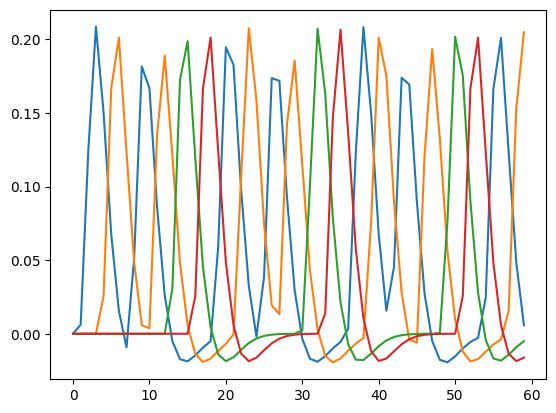

In [11]:
# Compute the convolved bestdesign matrix and evaluate design quality
best_design_fixed.designmatrix()
print(best_design_fixed.Xconv)
plt.plot(best_design_fixed.Xconv)

**The order is [0,1,0,1,2,3,0,1,0,1,2,3,0,1,0,1,2,3,0,1] as desired.** 

Therefore, by leveraging this parameter, you can fix your order and focus the optimization to the intertrial intervals.